In [1]:
import warnings
warnings.filterwarnings('ignore')

# Análise Exploratória de Dados (EDA)

O arquivo b3_stocks_1994_2020.csv contém o dataset que iremos analizar, nele temos informações básicas relativas a todas as ações negociadas na bolsa de valores B3 no período de julho de 1994 a dezembro de 2020.

Nesta seção, realizamos uma análise para entender melhor as características do conjunto de dados relacionado às ações da bolsa de valores. Utilizamos o ticker 'BBDC4' como exemplo, que é o identificador de uma ação na bolsa.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
ticker = 'BBDC4' # eh o identificador de uma ação na bolsa de valores, no caso este ticker pertence ao Banco Bradesco

In [4]:
def getDfTicker(df, ticker: str):
    return df[df['ticker'] == ticker]

In [5]:
df = pd.read_csv('data\\b3_stocks_1994_2020.csv', low_memory=False)
df.head()


,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


- datetime: Esta coluna representa o timestamp ou a data e hora em que as informações da ação foram registradas. Geralmente, é uma série temporal que permite analisar as variações ao longo do tempo.

- ticker: O ticker é um código único atribuído a cada ativo financeiro negociado em uma bolsa de valores. Ele serve como uma abreviação para identificar uma ação específica. No contexto do seu conjunto de dados, ticker indica qual ação específica está sendo observada.

- open: Este é o preço de abertura da ação no mercado financeiro. Refere-se ao valor pelo qual uma ação é negociada quando o mercado é aberto.

- close: O preço de fechamento representa o valor pelo qual uma ação é negociada quando o mercado é fechado. É um indicador crucial para avaliar o desempenho de uma ação durante um período específico.

- high: O preço mais alto (máximo) que a ação atingiu durante o período de tempo específico registrado na linha do dataset. Indica o ponto máximo de valor atingido pela ação durante o período.

- low: O preço mais baixo (mínimo) que a ação atingiu durante o período de tempo registrado na linha do dataset. Indica o ponto mínimo de valor atingido pela ação durante o período.

- volume: O volume de negociação é a quantidade total de ações que foram negociadas durante o período de tempo especificado. Representa a liquidez e a atividade do mercado para a ação.

In [6]:
dft = getDfTicker(df, ticker)

entrada = ['close', 'volume']
saida = ['close']

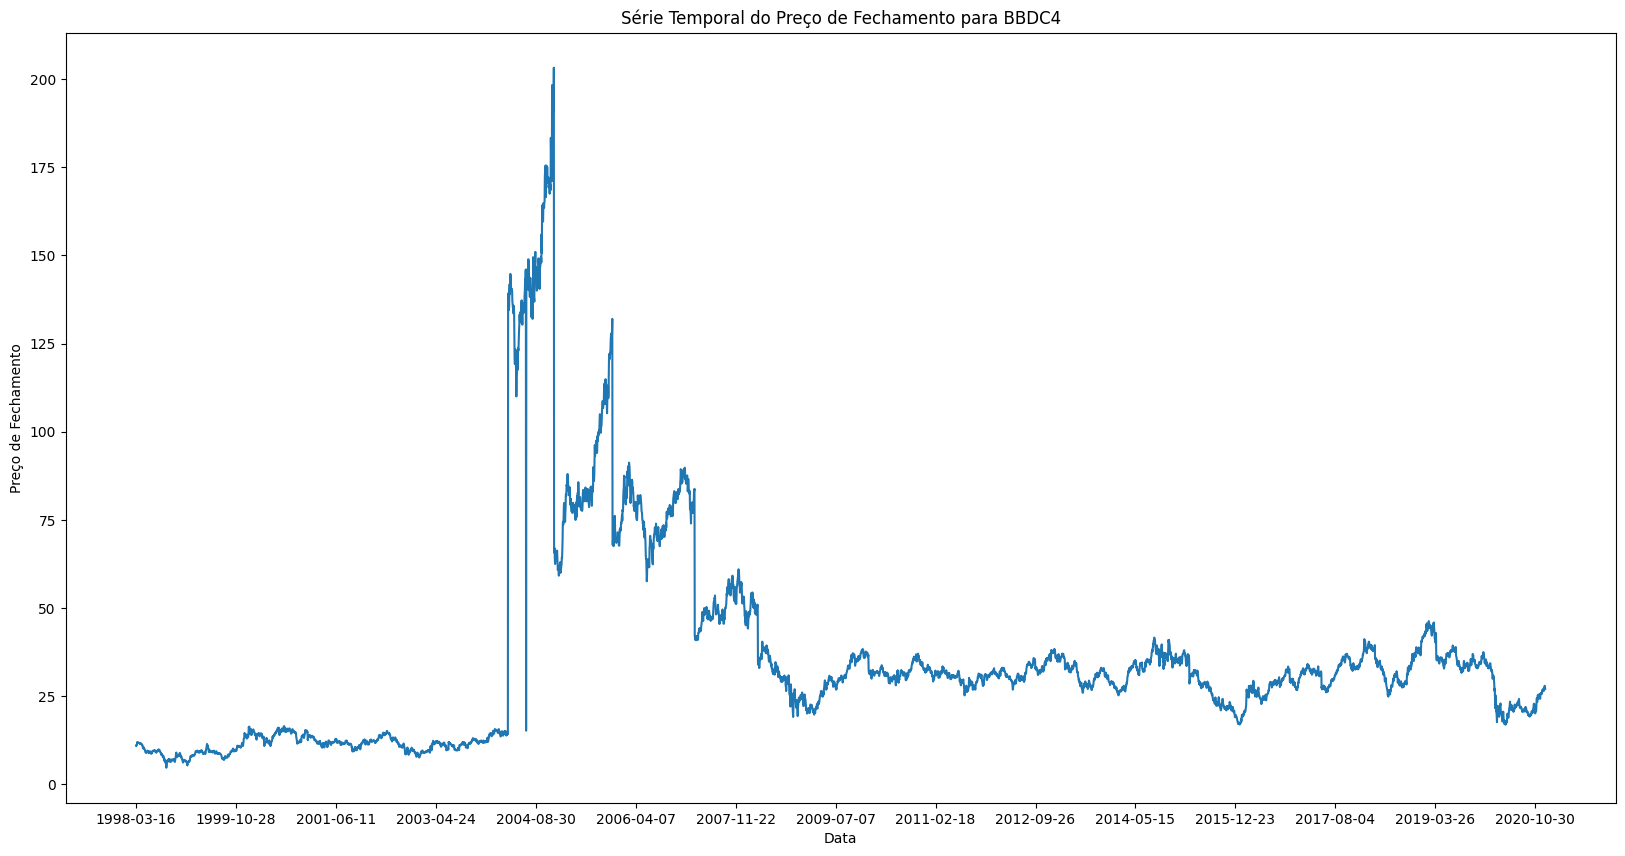

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft['datetime'], dft['close'])
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.title(f"Série Temporal do Preço de Fechamento para {ticker}")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.show()

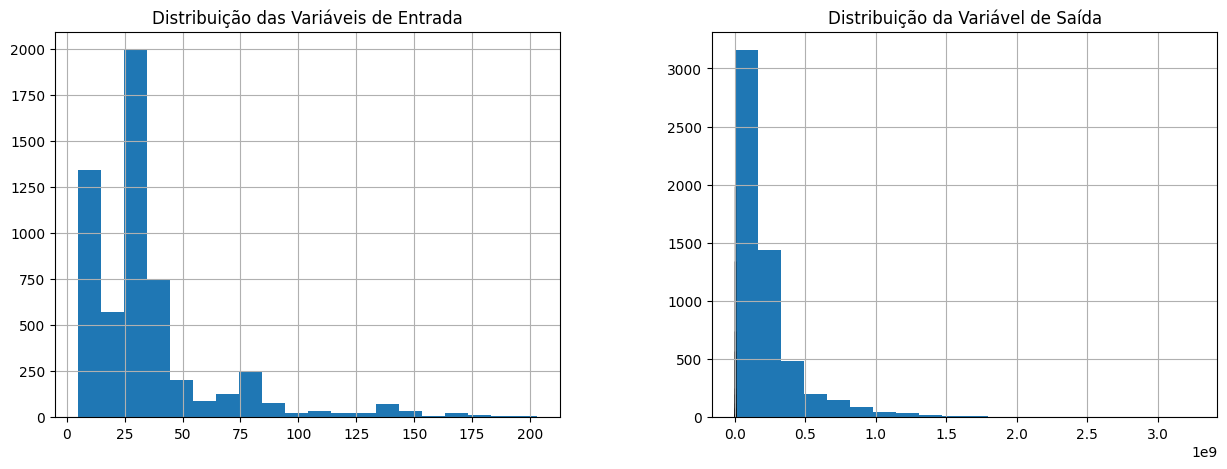

In [8]:
# Distribuição das Variáveis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dft[entrada].hist(ax=axes, bins=20)
axes[0].set_title("Distribuição das Variáveis de Entrada")
axes[1].hist(dft[saida].values, bins=20, color='skyblue', edgecolor='black')
axes[1].set_title("Distribuição da Variável de Saída")
plt.show()


## Funções

In [9]:
'''
Esta função cria janelas temporais a partir de um DataFrame (df). Uma janela temporal consiste em uma sequência
contínua de observações no DataFrame. size especifica o tamanho da janela, e ahead indica quantas observações à 
frente devem ser previstas. A função retorna duas listas, uma contendo as janelas de entrada (x) e outra contendo 
as saídas previstas (y)
'''
def createWindow(df, size, ahead):
    x, y = [], []

    for i in range(len(df) - size - ahead):
        x.append(df.iloc[i:i + size])
        y.append(df.iloc[i + size + ahead - 1])

    return x, y


In [10]:
'''
Normaliza as colunas especificadas (cols) dos DataFrames de entrada (dfX) e saída prevista (dfY). 
A normalização é feita em relação ao valor inicial, subtraindo 1 para representar as mudanças percentuais.
'''
def normCols(dfX, dfY, cols):
    normX = dfX[cols] / dfX[cols].iloc[0] - 1
    normY = dfY.to_frame().T[cols] / dfX[cols].iloc[0] - 1

    return normX, normY

'''
Realiza a operação inversa à normalização, ou seja, desnormaliza os DataFrames normalizados (dfNormX e dfNormY).
Retorna os DataFrames desnormalizados.
'''
def denormCols(dfX, dfNormX, dfNormY, cols):
    dfDenormX = dfX[cols].iloc[0] * (dfNormX[cols] + 1)
    dfDenormY = dfX[cols].iloc[0] * (dfNormY[cols] + 1)

    return dfDenormX, dfDenormY


In [11]:
'''
Essa função transforma as previsões normalizadas de um modelo de volta para a escala original 
dos dados, usando as informações contidas nas janelas temporais usadas para fazer as previsões. 
'''

def denormPreds(xWindows, normPreds, col):
    preds = np.zeros_like(normPreds)
    for i, window in enumerate(xWindows):
        preds[i] = window[col].iloc[0] * (normPreds[i] + 1)
    return preds

In [12]:
'''
Utiliza as funções anteriores para criar conjuntos de dados para treinamento de cnnos. 
Cria janelas temporais, normaliza as colunas de entrada e saída, e retorna arrays numpy 
prontos para treinamento. xCols é a lista de colunas de entrada e yCol é a coluna de 
saída a ser prevista.
'''
def createDataset(df, windowSize, ahead, xCols, yCol):
    xWindows, yWindows = createWindow(df, windowSize, ahead)

    xCols = xCols if isinstance(xCols, list) else [xCols]
    xLst, yLst = [], []

    for xWindow, yWindow in zip(xWindows, yWindows):

        xNorm, yNorm = normCols(xWindow, yWindow, xCols)

        xLst.append(xNorm.to_numpy())
        yLst.append(yNorm[yCol].to_numpy().astype('float').squeeze())

    return xWindows, yWindows, np.stack(xLst), np.stack(yLst)


In [13]:
'''
Divide os conjuntos de dados em conjuntos de treinamento e teste. percent determina a porcentagem dos 
dados a serem usados para treinamento, e o restante é usado para teste. Retorna uma tupla contendo
os conjuntos de treinamento e teste.
'''
def splitTrainTest(items, percent=0.8):
    results = []
    for item in items:
        split = int(len(item) * percent)
        results.append(item[:split])
        results.append(item[split:])

    return tuple(results)


# LSTM

As Long Short-Term Memory Networks, ou LSTMs, são uma variante especializada de redes neurais recorrentes (RNNs), projetadas para lidar com o problema do desaparecimento do gradiente, que é comum em RNNs tradicionais. As LSTMs foram propostas por Hochreiter & Schmidhuber em 1997 e têm sido amplamente utilizadas em tarefas relacionadas a sequências, como processamento de linguagem natural, reconhecimento de fala e séries temporais.

Estrutura Básica:

- Uma LSTM é composta por células de memória, portões de entrada, portões de esquecimento e portões de saída.
- Cada célula de memória mantém e atualiza uma "memória de longo prazo", permitindo a retenção de informações relevantes ao longo do tempo.

Portões:

- Os portões são componentes-chave das LSTMs e incluem o portão de entrada, o portão de esquecimento e o portão de saída.
- Portão de Entrada (Input Gate): Regula quais informações da entrada devem ser armazenadas na célula de memória.
- Portão de Esquecimento (Forget Gate): Decide quais informações antigas na célula de memória devem ser descartadas ou mantidas.
- Portão de Saída (Output Gate): Determina a saída da célula de memória com base na entrada atual e na memória de longo prazo.

Atualização da Célula de Memória:

- O estado da célula de memória é atualizado multiplicando a saída do portão de esquecimento pela memória existente e somando a multiplicação da saída do portão de entrada pelos candidatos a valores de atualização.

Backpropagation Through Time (BPTT):

- LSTMs utilizam o algoritmo de retropropagação através do tempo para otimização.
- O gradiente é passado ao longo da sequência temporal durante o treinamento, permitindo o aprendizado de dependências de longo prazo.

In [14]:
windowSize = 20
predictAhead = 1

xWindows, yWindows, xNorm, yNorm = createDataset(df=dft, windowSize=windowSize, ahead=predictAhead, xCols=entrada, yCol=saida)
xNorm.shape, yNorm.shape

((5620, 20, 2), (5620,))

In [15]:
# Split train and test packs
xTrain, xTest, yTrain, yTest = splitTrainTest([xWindows, yWindows], percent=0.85)
xNormTrain, xNormTest, yNormTrain, yNormTest = splitTrainTest([xNorm, yNorm], percent=0.85)

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout

lstm = keras.Sequential()

# Adiciona uma camada LSTM com 50 neurónios
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(xNormTrain.shape[1], len(entrada))))
# Adiciona uma camada de dropout para evitar overfitting
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))
# Camada de saida com 1 neuronio denso
lstm.add(Dense(units=1))

lstm.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
lstm.fit(
    xNormTrain, 
    yNormTrain,
    validation_data=(xNormTest, yNormTest),
    batch_size=64,
    epochs=10
)

Epoch 1/10


75/75 [==============================] - 11s 45ms/step - loss: 0.1494 - val_loss: 0.0026
Epoch 2/10
75/75 [==============================] - 2s 21ms/step - loss: 0.0571 - val_loss: 0.0021
Epoch 3/10
75/75 [==============================] - 2s 23ms/step - loss: 0.0515 - val_loss: 0.0018
Epoch 4/10
75/75 [==============================] - 2s 22ms/step - loss: 0.0425 - val_loss: 0.0019
Epoch 5/10
75/75 [==============================] - 2s 22ms/step - loss: 0.0367 - val_loss: 0.0017
Epoch 6/10
75/75 [==============================] - 2s 21ms/step - loss: 0.0343 - val_loss: 0.0020
Epoch 7/10
75/75 [==============================] - 2s 27ms/step - loss: 0.0285 - val_loss: 0.0013
Epoch 8/10
75/75 [==============================] - 2s 28ms/step - loss: 0.0298 - val_loss: 0.0011
Epoch 9/10
75/75 [==============================] - 2s 22ms/step - loss: 0.0254 - val_loss: 0.0013
Epoch 10/10
75/75 [==============================] - 2s 27ms/step - loss: 0.0263 - val_loss: 0.0013


In [57]:
# Previsão
normPreds = lstm.predict(xNormTest)
lstmPreds = denormPreds(xTest, normPreds, saida)
lstmY = denormPreds(xTest, yNormTest, saida)

27/27 [==============================] - 4s 8ms/step


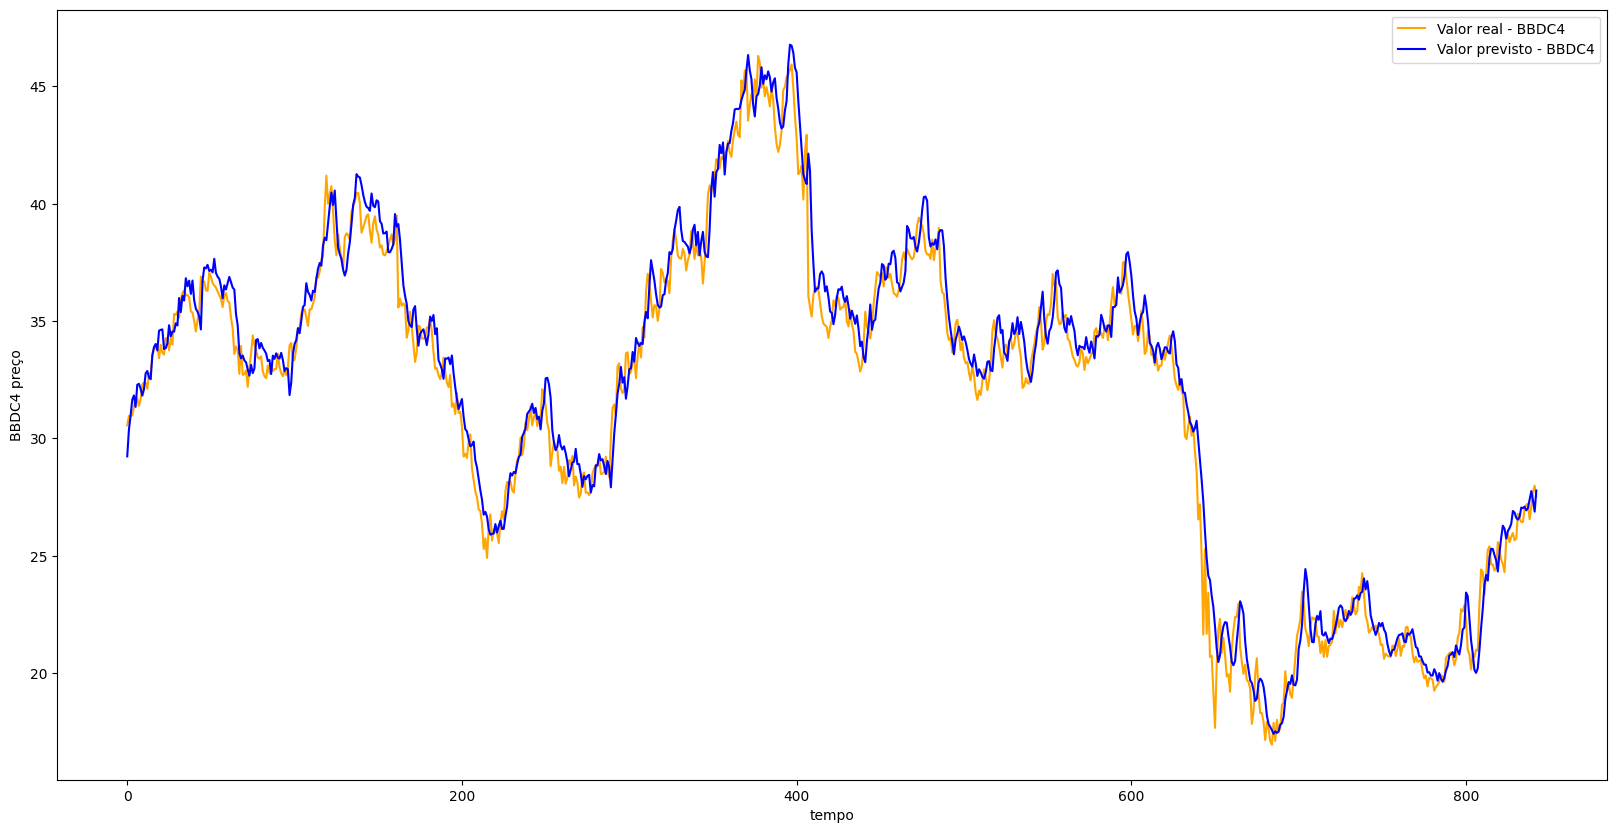

In [58]:
plt.figure(figsize=(20,10))
plt.plot(lstmY, color='orange', label=f"Valor real - {ticker}")
plt.plot(lstmPreds[:,0], color='blue', label=f"Valor previsto - {ticker}")
plt.xlabel("tempo")
plt.ylabel(f"{ticker} preço")
plt.legend()
plt.show()

# CNN

As Convolutional Neural Networks (CNNs) são uma classe de redes neurais profundas projetadas principalmente para tarefas de visão computacional, como classificação de imagem e detecção de objetos. No entanto, também podem ser adaptadas para tarefas de regressão.

Arquitetura Básica:

- As CNNs incluem camadas de convolução, pooling e camadas totalmente conectadas.
- As camadas de convolução extraem características espaciais das entradas.
- As camadas de pooling reduzem a dimensionalidade das características, preservando informações importantes.
- As camadas totalmente conectadas processam as características extraídas e geram a saída final.

Camadas de Convolução:

- As camadas de convolução aplicam filtros a pequenas regiões da entrada, permitindo a detecção de padrões locais.
- Os filtros aprendem características como bordas, texturas e padrões simples.

Camadas de Pooling:

- As camadas de pooling reduzem a resolução espacial da entrada, reduzindo a quantidade de parâmetros e computação.
- O pooling máximo ou médio é comumente usado para preservar as características mais importantes.

Camadas Totalmente Conectadas:

- As camadas totalmente conectadas processam características globalmente e geram a saída final.
- São comuns ao final da arquitetura da CNN.

In [59]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

cnn = keras.Sequential()

# Adicione uma camada convolucional 1D com 32 filtros, kernel_size 3, função de ativação 'relu' e mesma borda
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(xNormTrain.shape[1], len(entrada))))
cnn.add(MaxPooling1D(pool_size=2))  # Adicione uma camada de pooling para redução de dimensionalidade

# Adicione outra camada convolucional 1D com 64 filtros, kernel_size 3, função de ativação 'relu' e mesma borda
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling1D(pool_size=2))  # Mais uma camada de pooling

# Adicione uma camada Flatten para converter os dados para um vetor 1D antes de alimentar a camada densa
cnn.add(Flatten())

# Adicione uma camada densa com 128 neurônios e função de ativação 'relu'
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.5))  # Adicione uma camada de dropout para evitar overfitting

# Camada de saída com 1 neurônio para uma tarefa de regressão (ou ajuste para classificação, conforme necessário)
cnn.add(Dense(units=1))

# Compile o modelo
cnn.compile(optimizer='adam', loss='mean_squared_error')


In [60]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 32)            224       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [61]:
'''
Durante o treinamento, o callback ModelCheckpoint monitorará o desempenho do modelo na métrica
de validação e salvará os pesos no arquivo especificado sempre que uma melhoria for observada. 
Isso é útil para reter apenas os melhores pesos do modelo, economizando recursos e facilitando 
a recuperação do melhor modelo treinado.
'''

from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(
    filepath='weights_best.hdf5', 
    verbose=2, 
    save_best_only=True
)

In [62]:
cnn.fit(
    xNormTrain, 
    yNormTrain, 
    validation_data=(xNormTest, yNormTest), 
    epochs=40,
    batch_size=64,
    callbacks=[checkpointer]
)

Epoch 1/40


68/75 [==========================>...] - ETA: 0s - loss: 0.1601
Epoch 1: val_loss improved from inf to 0.00748, saving model to weights_best.hdf5
75/75 [==============================] - 4s 24ms/step - loss: 0.1585 - val_loss: 0.0075
Epoch 2/40
67/75 [=========================>....] - ETA: 0s - loss: 0.0630
Epoch 2: val_loss improved from 0.00748 to 0.00312, saving model to weights_best.hdf5
75/75 [==============================] - 1s 15ms/step - loss: 0.0573 - val_loss: 0.0031
Epoch 3/40
71/75 [===========================>..] - ETA: 0s - loss: 0.0738
Epoch 3: val_loss did not improve from 0.00312
75/75 [==============================] - 1s 7ms/step - loss: 0.0710 - val_loss: 0.0048
Epoch 4/40
69/75 [==========================>...] - ETA: 0s - loss: 0.0652
Epoch 4: val_loss did not improve from 0.00312
75/75 [==============================] - 0s 6ms/step - loss: 0.0614 - val_loss: 0.0040
Epoch 5/40
71/75 [===========================>..] - ETA: 0s - loss: 0.0565
Epoch 5: val_loss did no

In [63]:
normPreds = cnn.predict(xNormTest)
cnnPreds = denormPreds(xTest, normPreds, saida)
cnnY = denormPreds(xTest, yNormTest, saida)

 1/27 [>.............................] - ETA: 2s

27/27 [==============================] - 0s 2ms/step


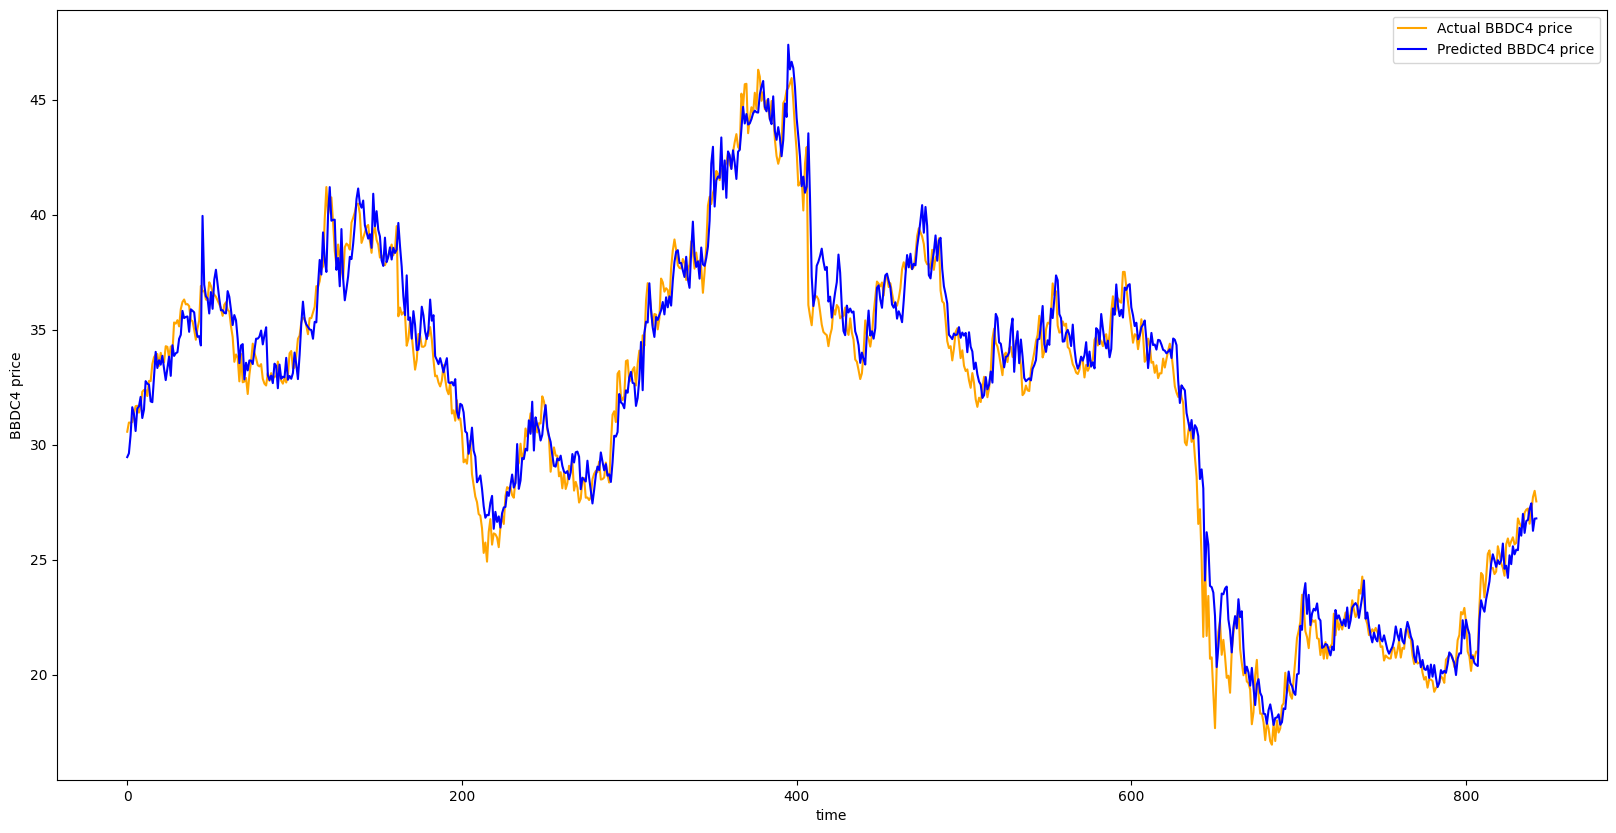

In [64]:
plt.figure(figsize=(20,10))
plt.plot(cnnY, color='orange', label=f"Actual {ticker} price")
plt.plot(cnnPreds[:,0], color='blue', label=f"Predicted {ticker} price")
plt.xlabel("time")
plt.ylabel(f"{ticker} price")
plt.legend()
plt.show()

# Feedforward Neural Network (FNN) 

A Feedforward Neural Network (Rede Neural de Avanço ou Rede Neural de Propagação Direta) é um tipo fundamental de arquitetura de rede neural, onde as informações fluem em uma única direção, da camada de entrada para a camada de saída, sem retroalimentação. Esta é a arquitetura mais simples e comum de uma rede neural.

Entrada (Input Layer):

- Camada Densa (Dense): A primeira camada densa possui 50 neurônios (ou unidades) e utiliza a função de ativação ReLU (Rectified Linear Unit). A entrada tem a forma (xNormTrain.shape[1], len(entrada)), o que sugere que ela aceita entradas relacionadas ao formato (número_de_janelas_temporais, número_de_características). A função de ativação ReLU ajuda a introduzir não linearidades na rede.

- Dropout: Uma camada de Dropout com uma taxa de 0.2 é adicionada após cada camada densa para reduzir o overfitting. O Dropout desativa aleatoriamente um determinado número de neurônios durante o treinamento para evitar que a rede se torne excessivamente dependente de neurônios específicos.

Camadas Intermediárias (Hidden Layers):

- Duas camadas densas adicionais com 50 neurônios cada e funções de ativação ReLU seguidas por camadas Dropout. Cada camada densa introduz mais complexidade e capacidade de aprendizado à rede.

Camada Flatten:

- Camada Flatten: Esta camada transforma os dados de entrada em uma forma unidimensional (aplanada). Isso é necessário para conectar as camadas densas finais.

Saída (Output Layer):

- Camada Densa (Dense): A última camada densa possui 1 neurônio, que é a camada de saída para a tarefa de regressão. A função de ativação padrão é linear, o que é apropriado para problemas de regressão, pois produzirá uma saída contínua.

Compilação:

- A rede é compilada usando o otimizador 'adam' e a função de perda 'mean_squared_error'. O otimizador 'adam' é uma escolha comum para treinamento de redes neurais, e a função de perda MSE (Erro Quadrático Médio) é adequada para problemas de regressão, onde o objetivo é minimizar a diferença ao quadrado entre as previsões e os valores reais.

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

fnn = Sequential()

# Adicione camadas densas para incorporar características temporais atrasadas
fnn.add(Dense(units=50, activation='relu', input_shape=(xNormTrain.shape[1], len(entrada))))
fnn.add(Dropout(0.2))

fnn.add(Dense(units=50, activation='relu'))
fnn.add(Dropout(0.2))

fnn.add(Dense(units=50, activation='relu'))
fnn.add(Dropout(0.2))

# Adicione camada Flatten para preparar para a camada densa final
fnn.add(Flatten())

# Adicione uma camada densa para a saída
fnn.add(Dense(units=1))

# Compile o modelo
fnn.compile(optimizer='adam', loss='mean_squared_error')


In [66]:
fnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 20, 50)            150       
                                                                 
 dropout_11 (Dropout)        (None, 20, 50)            0         
                                                                 
 dense_11 (Dense)            (None, 20, 50)            2550      
                                                                 
 dropout_12 (Dropout)        (None, 20, 50)            0         
                                                                 
 dense_12 (Dense)            (None, 20, 50)            2550      
                                                                 
 dropout_13 (Dropout)        (None, 20, 50)            0         
                                                                 
 flatten_3 (Flatten)         (None, 1000)             

In [67]:
fnn.fit(
    xNormTrain, 
    yNormTrain, 
    validation_data=(xNormTest, yNormTest), 
    epochs=20, 
    batch_size=64
)

Epoch 1/20


75/75 [==============================] - 2s 10ms/step - loss: 0.2597 - val_loss: 0.0049
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0677 - val_loss: 0.0026
Epoch 3/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0558 - val_loss: 0.0023
Epoch 4/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0527 - val_loss: 0.0017
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0425 - val_loss: 0.0021
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0502 - val_loss: 0.0023
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.0019
Epoch 8/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0372 - val_loss: 0.0016
Epoch 9/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0349 - val_loss: 0.0016
Epoch 10/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0016
Epoch 11/20
75/75 [==========

In [68]:
normPreds = fnn.predict(xNormTest)
fnnPreds = denormPreds(xTest, normPreds, saida)
fnnY = denormPreds(xTest, yNormTest, saida)


27/27 [==============================] - 0s 2ms/step


# Metricas de Avaliação

R² (R-squared):

- O coeficiente de determinação, também conhecido como R², é uma medida estatística que indica a proporção da variância na variável dependente que é previsível a partir da(s) variável(eis) independente(s). O R² varia de 0 a 1, onde 1 indica um ajuste perfeito do modelo aos dados.

R² Ajustado (Adjusted R-squared):

- O R² ajustado leva em consideração o número de preditores no modelo. Ele penaliza a inclusão de variáveis irrelevantes que não contribuem significativamente para a explicação da variabilidade da variável dependente.

MSE (Mean Squared Error):

- O Erro Quadrático Médio é a média dos quadrados dos erros entre os valores previstos e os valores reais. Quanto menor o MSE, melhor o modelo está ajustado aos dados.

RMSE (Root Mean Squared Error):

- O RMSE é a raiz quadrada do MSE, e representa a média dos erros absolutos. Ele fornece uma interpretação mais intuitiva dos erros do modelo na mesma unidade da variável de resposta.

MAPE (Mean Absolute Percentage Error):

- O Erro Médio Percentual Absoluto é uma métrica expressa como uma porcentagem que mede a precisão do modelo em relação às previsões. O MAPE calcula a média das porcentagens absolutas de erro.

MAE (Mean Absolute Error):

- O Erro Absoluto Médio é a média dos valores absolutos das diferenças entre os valores previstos e os valores reais. Ele fornece uma medida da magnitude média dos erros.

RMSLE (Root Mean Squared Logarithmic Error):

- O RMSLE é semelhante ao RMSE, mas é aplicado ao logaritmo dos valores previstos e reais. É útil quando as diferenças relativas são mais importantes do que as diferenças absolutas.

In [69]:
from sklearn.metrics import r2_score 

print(f"R2 para LSTM: {r2_score(lstmY, lstmPreds[:, 0]):.5f}")
print(f"R2 para CNN: {r2_score(cnnY, cnnPreds[:, 0]):.5f}")
print(f"R2 para FNN: {r2_score(fnnY, fnnPreds[:, 0]):.5f}")

R2 para LSTM: 0.97342
R2 para CNN: 0.97108
R2 para FTLFN: 0.95601


In [70]:
def adjustedR2(yTrue, yPred, n):
    r2 = r2_score(yTrue, yPred)
    return 1 - (1 - r2) * (n - 1) / (n - 2)

print(f"Adjusted R2 para LSTM: {adjustedR2(lstmY, lstmPreds[:, 0], len(lstmY)):.5f}")
print(f"Adjusted R2 para CNN: {adjustedR2(cnnY, cnnPreds[:, 0], len(cnnY)):.5f}")
print(f"Adjusted R2 para FNN: {adjustedR2(fnnY, fnnPreds[:, 0], len(fnnY)):.5f}")

Adjusted R2 para LSTM: 0.97339
Adjusted R2 para CNN: 0.97104
Adjusted R2 para FTLFN: 0.95596


In [71]:
from sklearn.metrics import mean_squared_error

print(f"MSE para LSTM: {mean_squared_error(lstmY, lstmPreds[:, 0]):.5f}")
print(f"MSE para CNN: {mean_squared_error(cnnY, cnnPreds[:, 0]):.5f}")
print(f"MSE para FNN: {mean_squared_error(fnnY, fnnPreds[:, 0]):.5f}")

MSE para LSTM: 1.21868
MSE para CNN: 1.32619
MSE para FTLFN: 2.01711


In [72]:
print(f"RMSE para LSTM: {np.sqrt(mean_squared_error(lstmY, lstmPreds[:, 0])):.5f}")
print(f"RMSE para CNN: {np.sqrt(mean_squared_error(cnnY, cnnPreds[:, 0])):.5f}")
print(f"RMSE para FNN: {np.sqrt(mean_squared_error(fnnY, fnnPreds[:, 0])):.5f}")

RMSE para LSTM: 1.10394
RMSE para CNN: 1.15160
RMSE para FTLFN: 1.42025


In [73]:
def mape(yTrue, yPred):
    return np.mean(np.abs((yTrue - yPred) / yTrue)) * 100

print(f"MAPE para LSTM: {mape(lstmY, lstmPreds[:, 0]):.5f}%")
print(f"MAPE para CNN: {mape(cnnY, cnnPreds[:, 0]):.5f}%")
print(f"MAPE para FNN: {mape(fnnY, fnnPreds[:, 0]):.5f}%")

MAPE para LSTM: 2.76129%
MAPE para CNN: 2.79302%
MAPE para FTLFN: 3.52711%


In [74]:
from sklearn.metrics import mean_absolute_error

print(f"MAE para LSTM: {mean_absolute_error(lstmY, lstmPreds[:, 0]):.5f}")
print(f"MAE para CNN: {mean_absolute_error(cnnY, cnnPreds[:, 0]):.5f}")
print(f"MAE para FNN: {mean_absolute_error(fnnY, fnnPreds[:, 0]):.5f}")

MAE para LSTM: 0.82939
MAE para CNN: 0.83834
MAE para FTLFN: 1.07524


In [75]:

from sklearn.metrics import mean_squared_log_error

print(f"RMSLE para LSTM: {np.sqrt(mean_squared_log_error(lstmY, lstmPreds[:, 0])):.5f}")
print(f"RMSLE para CNN: {np.sqrt(mean_squared_log_error(cnnY, cnnPreds[:, 0])):.5f}")
print(f"RMSLE para FNN: {np.sqrt(mean_squared_log_error(fnnY, fnnPreds[:, 0])):.5f}")

RMSLE para LSTM: 0.03606
RMSLE para CNN: 0.03789
RMSLE para FTLFN: 0.04649


Com base nos resultados obtidos para os modelos LSTM (Long Short-Term Memory), CNN (Convolutional Neural Network) e FNN (Feedforward Neural Network), podemos fazer as seguintes interpretações:

Todos os modelos apresentam altos valores de R² e R² ajustado, indicando que eles são capazes de explicar uma porção significativa da variabilidade nos dados. O modelo LSTM obteve o melhor desempenho, seguido pelo CNN e FNN.

O RMSLE leva em consideração as diferenças relativas entre os valores previstos e reais em uma escala logarítmica. Todos os modelos apresentam valores baixos, com o LSTM e o CNN destacando-se em termos de precisão.

Considerando todas as métricas avaliadas, o modelo LSTM demonstrou ser o mais eficaz na previsão dos preços da ação. Ele apresentou um desempenho superior ao CNN e FNN em todas as métricas analisadas. 

O CNN também teve um desempenho sólido, enquanto o FNN ficou um pouco atrás em termos de precisão, conforme indicado pelas métricas de avaliação. Esses resultados sugerem que modelos baseados em redes neurais recorrentes, como o LSTM, são promissores para tarefas de previsão em séries temporais financeiras. 

Importante destacar que o CNN não foi projetado para tarefas de previsão de séries temporais, mas sim para tarefas de classificação de imagens. Portanto, o fato de ter obtido um desempenho comparável ao LSTM é bastante impressionante.